In [168]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data'
MODEL_PATH = '/home/dmig/work/upsell/model'

In [3]:
RESULT_PATH = '/home/dmig/work/upsell/result/summary'

## Load data

In [4]:
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart04 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201904.pkl'))
df_mart05 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201905.pkl'))

df_input06 = pd.read_pickle(os.path.join(DATA_PATH, 'df_input_201906.pkl'))

In [5]:
df_mart01.shape, df_mart04.shape, df_mart05.shape, df_input06.shape

((18176215, 81), (18626176, 81), (18707537, 81), (18855464, 80))

In [37]:
del df_input06

In [38]:
gc.collect()

1379

## Load New Feature
1. avg_subscription_period_01.pkl
2. fee_chg_cnt_01.pkl
3. fee_chg_period_01.pkl
4. new_avg_01.pl

In [18]:
from functools import reduce

def merge_df(df_mart, ym):
    
    df_tmp = df_mart[['svc_mgmt_num', 'avg_subscription_period']]
    
    avg_sub = pd.read_pickle(os.path.join(DATA_PATH, 'avg_subscription_period_{}.pkl'.format(ym)))
    fee_chg_cnt = pd.read_pickle(os.path.join(DATA_PATH, 'fee_chg_cnt_{}.pkl'.format(ym)))
    fee_chg_period = pd.read_pickle(os.path.join(DATA_PATH, 'fee_chg_period_{}.pkl'.format(ym)))
    new_avg = pd.read_pickle(os.path.join(DATA_PATH, 'new_avg_{}.pkl'.format(ym)))
    
    print('avg_sub: ', avg_sub.shape)
    print('fee_chg_cnt: ', fee_chg_cnt.shape)
    print('fee_chg_period: ', fee_chg_period.shape)
    print('new_avg: ', new_avg.shape)
    
    avg_sub.columns = ['svc_mgmt_num', 'fixed_avg_subsription_period']
    fee_chg_cnt.columns = ['svc_mgmt_num', 'fee_chg_cnt']
    fee_chg_period.columns = ['svc_mgmt_num', 'fee_chg_period']
    new_avg.columns = ['svc_mgmt_num', 'new_avg_subsription_period']
    
    df_list = [df_tmp, avg_sub, fee_chg_cnt, new_avg, fee_chg_period]
    
    t1 = time.time()
    df_merged = reduce(lambda left, right: pd.merge(left, right, on=['svc_mgmt_num'], how='left'), df_list)
    print('elapsed time:', time.time()-t1)
    
    return df_merged

In [40]:
df_merged01 = merge_df(df_mart01, '01')

avg_sub:  (18805584, 2)
fee_chg_cnt:  (18805584, 2)
fee_chg_period:  (28947964, 2)
new_avg:  (18805584, 2)
elapsed time: 141.12786173820496


In [41]:
df_merged01.shape

(18176215, 6)

In [42]:
df_merged01.head()

svc_mgmt_num  avg_subscription_period  fixed_avg_subsription_period  \
0   1000160911                    640.0                        1031.0   
1   1000604111                    815.0                         928.0   
2   1001413217                    727.5                        1193.0   
3   1003398410                    716.0                       -9999.0   
4   1004451103                    624.5                         912.0   

   fee_chg_cnt  new_avg_subsription_period  fee_chg_period  
0            1                      1031.0           106.0  
1            1                       928.0           559.0  
2            1                      1193.0           119.0  
3            0                     -9999.0           573.0  
4            1                       912.0           194.0

In [44]:
df_merged04 = merge_df(df_mart04, '04')
df_merged05 = merge_df(df_mart05, '05')

avg_sub:  (19254342, 2)
fee_chg_cnt:  (19254342, 2)
fee_chg_period:  (29973673, 2)
new_avg:  (19254342, 2)
elapsed time: 145.74167776107788
avg_sub:  (19306174, 2)
fee_chg_cnt:  (19306174, 2)
fee_chg_period:  (30313644, 2)
new_avg:  (19306174, 2)
elapsed time: 145.22873401641846


In [45]:
df_merged01.isnull().sum(), df_merged04.isnull().sum(), df_merged05.isnull().sum()

(svc_mgmt_num                        0
 avg_subscription_period             0
 fixed_avg_subsription_period        0
 fee_chg_cnt                         0
 new_avg_subsription_period          0
 fee_chg_period                  39182
 dtype: int64, svc_mgmt_num                        0
 avg_subscription_period             0
 fixed_avg_subsription_period        0
 fee_chg_cnt                         0
 new_avg_subsription_period          0
 fee_chg_period                  53823
 dtype: int64, svc_mgmt_num                        0
 avg_subscription_period             0
 fixed_avg_subsription_period    40053
 fee_chg_cnt                     40053
 new_avg_subsription_period      40053
 fee_chg_period                  53447
 dtype: int64)

### [TODO] 추후 확인
1. 5월에 3개 변수가 null인 이유는 mmkt_svc_bas_f에 해당 svc_mgmt_num 값이 없기 때문임.
    - 우리 기준이 mmkt이므로 모델링에서 null인 애들은 제거
2. fee_chg_period 값이 null인 이유는 해당 svc_mgmt_num들이 change_fee_history에 없기 때문
3. 위에 missing value 가 생기는 게 어떤 trend가 있다면.... 큰일

## Feature engineering 실험
1. fixed_avg 추가 -> 제대로 된 값이 들어갔을 때 성능이 어떻게 되는지?
2. 새로운 feature 들 추가 -> 성능 향상에 도움이 되는지?

In [54]:
# 모델링에 제거할 애들
del_svc_list = list(df_merged05[df_merged05['fee_chg_cnt'].isnull()].svc_mgmt_num)

In [60]:
total_feature = list(df_mart01.columns)
feature_cols = [c for c in total_feature if c not in ['svc_mgmt_num', 'label']]

## update avg feature

In [59]:
df_mart01['avg_subscription_period'] = df_merged01['fixed_avg_subsription_period']
df_mart04['avg_subscription_period'] = df_merged04['fixed_avg_subsription_period']
df_mart05['avg_subscription_period'] = df_merged05['fixed_avg_subsription_period']

In [61]:
def lgb_model(x_trn, y_trn, x_val, y_val, feature_cols=feature_cols):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'num_leaves': 64,
        'learning_rate': 0.05,
        'num_threads': 30,
    }

    lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
    lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=500,
                    early_stopping_rounds=100,
                    verbose_eval=200)
    print('elapsed time:', time.time()-t1)
        
    return clf

In [62]:
# train
train_result = make_train_data(df_mart04)
x_trn = train_result['trn']['x']
y_trn = train_result['trn']['y']
x_val = train_result['val']['x']
y_val = train_result['val']['y']

lgb_clf = lgb_model(x_trn, y_trn, x_val, y_val, feature_cols=feature_cols)

make_train_data +++
label/sample:  0.2
sample/total:  0.13686330463107405
make_data_for_modeling---
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.878734	valid_1's auc: 0.875258
[400]	training's auc: 0.894815	valid_1's auc: 0.890107
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.898818	valid_1's auc: 0.893334
elapsed time: 128.35663652420044


In [63]:
test_result = make_test_data(df_mart01)
x_test = test_result['x']
y_test = test_result['y']

       acc    recall  precision  f1_score       auc
0  0.72802  0.832559   0.054157  0.101698  0.860638
         pred: 1   pred: 0
true: 1   279834     56279
true: 0  4887280  12952822


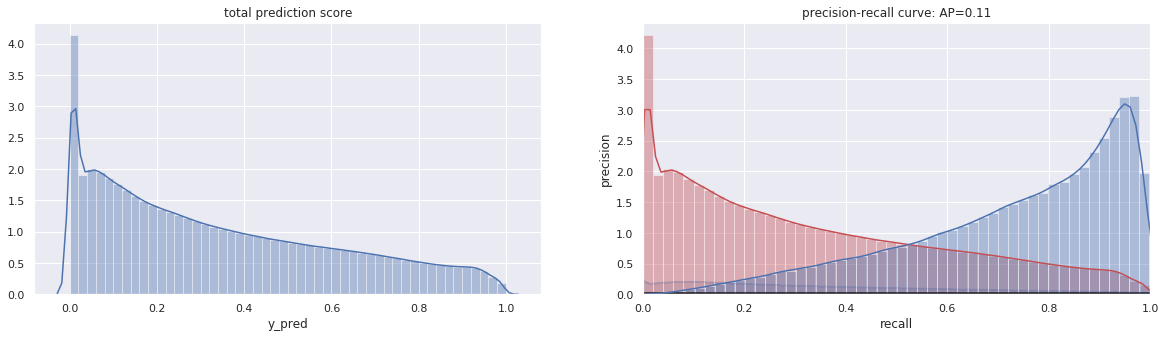

In [64]:
eval_result = evaluate(x_test, y_test.label.values, lgb_clf, clf_name='lgb')

- baseline과 비교했을 때 0을 0으로 잡아내는 능력이 낮아짐
- 전반적인 performance도 모두 하락(AP: 0.19 -> 0.11)

## 새로운 feature 추가

In [65]:
df_merged01.head()

svc_mgmt_num  avg_subscription_period  fixed_avg_subsription_period  \
0   1000160911                    640.0                        1031.0   
1   1000604111                    815.0                         928.0   
2   1001413217                    727.5                        1193.0   
3   1003398410                    716.0                       -9999.0   
4   1004451103                    624.5                         912.0   

   fee_chg_cnt  new_avg_subsription_period  fee_chg_period  
0            1                      1031.0           106.0  
1            1                       928.0           559.0  
2            1                      1193.0           119.0  
3            0                     -9999.0           573.0  
4            1                       912.0           194.0

In [66]:
df_mart01['fee_chg_cnt'] = df_merged01['fee_chg_cnt']
df_mart04['fee_chg_cnt'] = df_merged04['fee_chg_cnt']
df_mart05['fee_chg_cnt'] = df_merged05['fee_chg_cnt']

df_mart01['new_avg_subsription_period'] = df_merged01['new_avg_subsription_period']
df_mart04['new_avg_subsription_period'] = df_merged04['new_avg_subsription_period']
df_mart05['new_avg_subsription_period'] = df_merged05['new_avg_subsription_period']

df_mart01['fee_chg_period'] = df_merged01['fee_chg_period']
df_mart04['fee_chg_period'] = df_merged04['fee_chg_period']
df_mart05['fee_chg_period'] = df_merged05['fee_chg_period']

In [67]:
total_feature_cols = feature_cols + ['fee_chg_cnt', 'new_avg_subsription_period', 'fee_chg_period']

In [68]:
# train
train_result = make_train_data(df_mart04)
x_trn = train_result['trn']['x']
y_trn = train_result['trn']['y']
x_val = train_result['val']['x']
y_val = train_result['val']['y']

lgb_clf = lgb_model(x_trn, y_trn, x_val, y_val, feature_cols=total_feature_cols)

make_train_data +++
label/sample:  0.2
sample/total:  0.13686330463107405
make_data_for_modeling---
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.878227	valid_1's auc: 0.87503
[400]	training's auc: 0.894129	valid_1's auc: 0.889664
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.898275	valid_1's auc: 0.893062
elapsed time: 122.83852005004883


In [69]:
zz

In [ ]:
df_mart01.sort_values()

In [78]:
df_fea = pd.DataFrame({
    'feature': lgb_clf.feature_name(),
    'importance': lgb_clf.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

In [88]:
df_fea[df_fea['feature'].isin(['fee_chg_cnt', 'new_avg_subsription_period', 'fee_chg_period', 'avg_subscription_period'])]

feature   importance
81              fee_chg_period  3168.944208
44     avg_subscription_period   829.316601
80  new_avg_subsription_period   544.107002
79                 fee_chg_cnt    30.066401

In [89]:
df_fea.head(20)

feature    importance
49               real_avg_arpu  4.560499e+06
46             real_arpu_bf_m1  2.995769e+06
53            data_usage_ratio  1.939043e+06
6            last_equip_period  1.794775e+06
48             real_arpu_bf_m3  1.262488e+06
47             real_arpu_bf_m2  1.237141e+06
7                  bas_fee_amt  7.976808e+05
8              bas_ofr_data_gb  6.361792e+05
1                          age  6.187182e+05
50           bf_m3_fee_chg_cnt  2.883535e+05
27      data_usage_in_gb_bf_m1  2.238950e+05
54  bf_m6_data_usage_ratio_avg  2.212973e+05
12                   family_yn  1.931543e+05
78                     channel  1.924465e+05
30                 overage_bf0  1.820206e+05
69          mth_cnsl_cnt_bf_m0  1.148093e+05
45            avg_chg_duration  1.070080e+05
9                  eqp_out_prc  1.014130e+05
17          avg_twld_visit_cnt  8.839314e+04
42                  sec_dev_yn  8.585046e+04

In [94]:
sample = df_mart01.sample(frac=0.1)

In [116]:
df_tmp.shape

(12804031, 84)

In [121]:
for amount, count, in df_tmp['bas_ofr_data_gb'].value_counts().sort_index().items():
    print('='*50)
    print('base offer data gb: ', amount)
    print('total_count: ', count)
    
    target_cnt = df_tmp[df_tmp['bas_ofr_data_gb']==amount]['label'].sum()
    
    print('target ratio: ', target_cnt/count)

base offer data gb:  0.0001
total_count:  2325411
target ratio:  0.017784383061746935
base offer data gb:  0.0048828125
total_count:  136
target ratio:  0.0
base offer data gb:  0.009765625
total_count:  35965
target ratio:  0.0
base offer data gb:  0.0146484375
total_count:  87
target ratio:  0.0
base offer data gb:  0.0390625
total_count:  20797
target ratio:  0.0
base offer data gb:  0.048828125
total_count:  641
target ratio:  0.0
base offer data gb:  0.09765625
total_count:  81480
target ratio:  0.06476435935198822
base offer data gb:  0.1171875
total_count:  394
target ratio:  0.0
base offer data gb:  0.146484375
total_count:  1026
target ratio:  0.02631578947368421
base offer data gb:  0.244140625
total_count:  230196
target ratio:  0.013219169750994804
base offer data gb:  0.29296875
total_count:  1923202
target ratio:  0.026830774926398786
base offer data gb:  0.439453125
total_count:  26
target ratio:  0.038461538461538464
base offer data gb:  0.48828125
total_count:  1050415

In [115]:
df_tmp.groupby(['bas_ofr_data_gb', 'label']).size()

bas_ofr_data_gb  label
0.000100         0        2284055
                 1          41356
0.004883         0            136
0.009766         0          35965
0.014648         0             87
0.039062         0          20797
0.048828         0            641
0.097656         0          76203
                 1           5277
0.117188         0            394
0.146484         0            999
                 1             27
0.244141         0         227153
                 1           3043
0.292969         0        1871601
                 1          51601
0.439453         0             25
                 1              1
0.488281         0        1039143
                 1          11272
0.537109         0         278126
                 1           5089
0.585938         0          21622
                 1            187
0.634766         0          86419
                 1           3345
0.683594         0          31464
                 1           1309
0.732422         0       

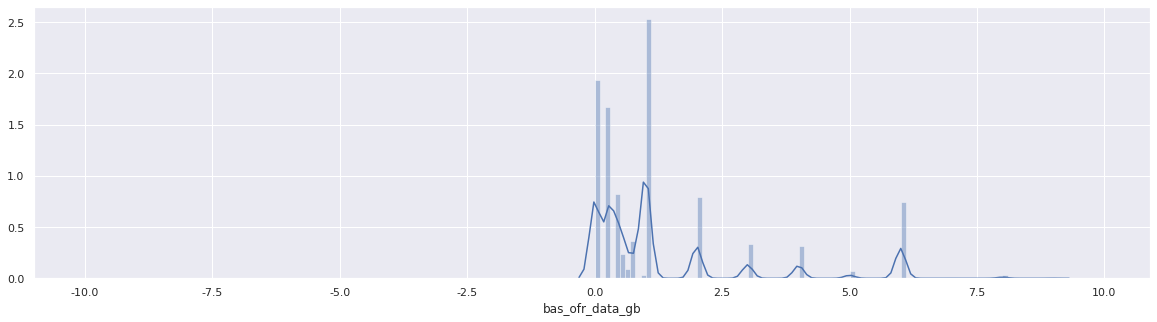

In [109]:
sns.distplot(sample[sample.label==0]['bas_ofr_data_gb'], bins=np.arange(-10, 10,0.1) )


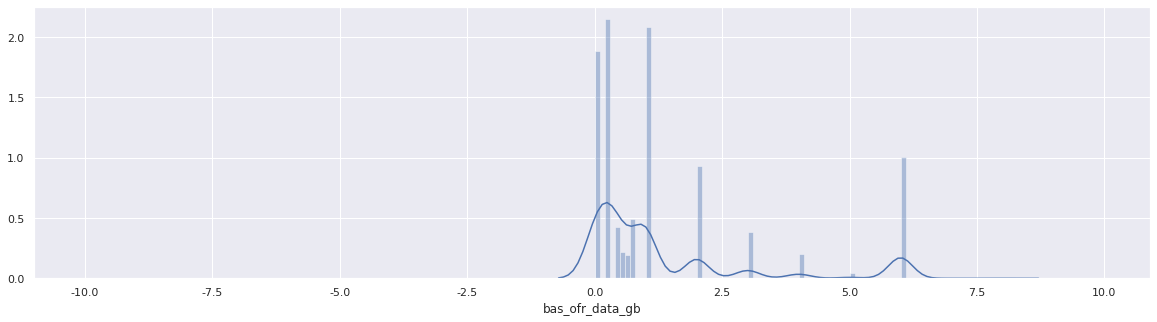

In [110]:
sns.distplot(sample[sample.label==1]['bas_ofr_data_gb'], bins=np.arange(-10, 10,0.1))

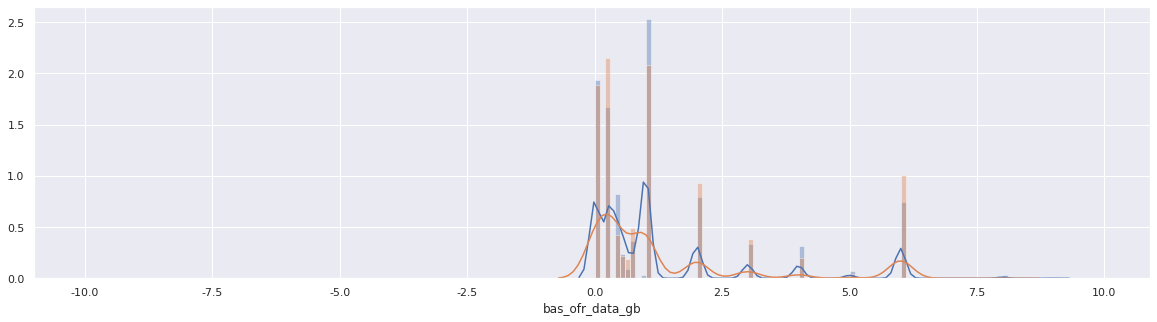

In [108]:
sns.distplot(sample[sample.label==0]['bas_ofr_data_gb'], bins=np.arange(-10, 10,0.1) )
sns.distplot(sample[sample.label==1]['bas_ofr_data_gb'], bins=np.arange(-10, 10,0.1))

## 일단 기존 문제는 해결했으니, 5월 training 수행

In [133]:
def lgb_model(x_trn, y_trn, x_val, y_val, feature_cols=feature_cols):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'num_leaves': 32,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'num_threads': 40,
    }

    lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
    lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=3000,
                    early_stopping_rounds=50,
                    verbose_eval=200)
    print('elapsed time:', time.time()-t1)
        
    return clf

In [124]:
# train
train_result = make_train_data(df_mart05)
x_trn = train_result['trn']['x']
y_trn = train_result['trn']['y']
x_val = train_result['val']['x']
y_val = train_result['val']['y']

In [132]:
lgb_clf = lgb_model(x_trn, y_trn, x_val, y_val, feature_cols=total_feature_cols)

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.811989	valid_1's auc: 0.810515
[400]	training's auc: 0.818579	valid_1's auc: 0.815713
[600]	training's auc: 0.822048	valid_1's auc: 0.817467
[800]	training's auc: 0.824936	valid_1's auc: 0.818688
[1000]	training's auc: 0.827499	valid_1's auc: 0.819477
[1200]	training's auc: 0.82977	valid_1's auc: 0.820014
[1400]	training's auc: 0.832082	valid_1's auc: 0.820611
[1600]	training's auc: 0.834084	valid_1's auc: 0.820906
[1800]	training's auc: 0.836024	valid_1's auc: 0.821162
[2000]	training's auc: 0.837974	valid_1's auc: 0.821408
[2200]	training's auc: 0.839821	valid_1's auc: 0.821602
[2400]	training's auc: 0.841538	valid_1's auc: 0.821656
[2600]	training's auc: 0.843243	valid_1's auc: 0.821726
[2800]	training's auc: 0.844885	valid_1's auc: 0.821757
[3000]	training's auc: 0.846522	valid_1's auc: 0.821853
Early stopping, best iteration is:
[2924]	training's auc: 0.84595	valid_1's auc: 0.82186
elapsed time:

## 현재 재출된 모델

In [129]:
# 3000번만 돌린 모델
save_model(lgb_clf, os.path.join(MODEL_PATH, 'update_model0729.pkl'))

save model to  /home/dmig/work/upsell/model/update_model0729.pkl


In [154]:
best_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'learning_rate': 0.05,
    'num_threads': 40,
    'num_leaves': 67,
    'lambda_l1': 61,
    'lambda_l2': 451,
    'feature_fraction': 0.7
}

In [157]:
# train
train_result = make_train_data(df_mart05)
x_trn = train_result['trn']['x']
y_trn = train_result['trn']['y']
x_val = train_result['val']['x']
y_val = train_result['val']['y']

make_train_data +++
label/sample:  0.2
sample/total:  0.11652977086187241
make_data_for_modeling---


In [158]:
lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=total_feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=total_feature_cols)

In [159]:
t1 = time.time()
clf = lgb.train(best_params,
               train_set = lgb_trn,
               valid_sets=[lgb_trn, lgb_val],
               num_boost_round=5000,
               early_stopping_rounds=100,
               verbose_eval=250)
print('elapsed time: ', time.time() - t1)

Training until validation scores don't improve for 100 rounds.
[250]	training's auc: 0.8179	valid_1's auc: 0.815684
[500]	training's auc: 0.824414	valid_1's auc: 0.819984
[750]	training's auc: 0.827957	valid_1's auc: 0.821403
[1000]	training's auc: 0.830587	valid_1's auc: 0.822109
[1250]	training's auc: 0.832985	valid_1's auc: 0.822648
[1500]	training's auc: 0.835034	valid_1's auc: 0.82288
[1750]	training's auc: 0.836874	valid_1's auc: 0.823044
[2000]	training's auc: 0.83866	valid_1's auc: 0.823191
[2250]	training's auc: 0.8405	valid_1's auc: 0.823532
[2500]	training's auc: 0.842171	valid_1's auc: 0.823602
[2750]	training's auc: 0.843867	valid_1's auc: 0.823686
[3000]	training's auc: 0.845402	valid_1's auc: 0.823741
Early stopping, best iteration is:
[3015]	training's auc: 0.845487	valid_1's auc: 0.823746
elapsed time:  575.7245118618011


In [160]:
save_model(clf, '/home/dmig/work/upsell/model/parameter_tuning_model0731.pkl')

save model to  /home/dmig/work/upsell/model/parameter_tuning_model0731.pkl


In [181]:
from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive

In [187]:
datetime.datetime.now().month

7

In [185]:
import datetime
time.time()

1564550449.749972

In [192]:
df_mart04.shape

(18626176, 84)

In [203]:
from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [1]:
def submit_to_item_reco_test(df_test, test_ym, model, model_name, feature_cols):
    """
    학습된 model의 offline test 결과를 comm.item_reco_test에 upload
    
    Args:
        - df_test: 테스트에 사용할 데이터(분석가 모두 공통이여야 함)
        - test_ym: 테스트 데이터의 년월
        - model: 학습된 모델
        - model_name: 모델명
        - feature_cols: 모델 학습에 사용된 feature column list
        
    Returns:
        - upload된 dataframe
        
    """
    
    print('test_ym: ', test_ym)
    print('model name: ', model_name)
    
    # calculate score
    print('calculate score +++')
    df = df_test.copy()
    df['score'] = np.round(model.predict(df[feature_cols]), 4)
    
    # make submit format
    print('make submit format +++')
    df_submit = df[['svc_mgmt_num', 'score']]
    df_submit['prod_id'] = 'RC00000001'
    df_submit['prod_nm'] = '요금제업셀가망'
    df_submit['reco_type'] = 'upsell'
    df_submit['model'] = model_name
    df_submit['ym'] = test_ym
    
    # load to hive
    print('load_to_hive +++')
    conn = hive_connection('dmig')
    load_to_hive(conn, 
                 df_submit[['svc_mgmt_num', 'prod_id', 'prod_nm', 'score', 'reco_type', 'model', 'ym']], 
                 "dumbo.item_reco_test_upsell")
    
    # insert to comm.item_reco_test
    print('insert_to_item_reco_test +++')
    insert_sql = """
        INSERT  OVERWRITE TABLE comm.item_reco_test PARTITION (reco_type, model, ym)
        SELECT  *
        FROM    dumbo.item_reco_test_upsell
    """
    conn = hive_connection('dmig')
    send_query(conn, insert_sql) 
    
    # drop dumbo table
    print('drop dumbo table +++')
    conn = hive_connection('dmig')
    send_query(conn, 'drop table dumbo.item_reco_test_upsell')
    
    return df_submit

In [215]:
conn = hive_connection('dmig')
send_query(conn, 'drop table dumbo.item_reco_test_upsell')

2019-07-31 15:56:55,909 - YE_HIVE - INFO - Query 'drop table dumbo.item_reco_test_upsell' is done


In [214]:
df_submit = submit_to_item_reco_test(df_mart04, '201904', clf, 'dominic_lgbm_05_20190731', total_feature_cols)

test_ym:  201904
model name:  dominic_lgbm_05_20190731
calculate score +++
make submit format +++
load_to_hive +++
2019-07-31 15:42:24,364 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_test_upsell (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, ym string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-07-31 15:42:24,381 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-07-31 15:43:23,902 - YE_HIVE - INFO - Loading data to HDFS... 
2019-07-31 15:43:55,278 - YE_HIVE - INFO - Loading to table dumbo.item_reco_test_upsell is done
insert_to_item_reco_test +++
2019-07-31 15:44:13,049 - YE_HIVE - INFO - Query '
        INSERT  OVERWRITE TABLE comm.item_reco_test PARTITION (reco_type, model, ym)
        SELECT  *
        FROM    dumbo.item_reco_test_upsell
    ' is done


In [217]:
model01 = load_model(os.path.join(MODEL_PATH, 'model_201901.pkl'))
model05 = load_model(os.path.join(MODEL_PATH, 'model_201905.pkl'))

load model from  /home/dmig/work/upsell/model/model_201901.pkl
load model from  /home/dmig/work/upsell/model/model_201905.pkl


In [219]:
df_submit = submit_to_item_reco_test(df_mart04, '201904', model01, 'dominic_old_lgbm_01_20190731', feature_cols)

test_ym:  201904
model name:  dominic_old_lgbm_01_20190731
calculate score +++
make submit format +++
load_to_hive +++
2019-07-31 16:04:23,444 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_test_upsell (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, ym string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-07-31 16:04:23,462 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-07-31 16:05:25,712 - YE_HIVE - INFO - Loading data to HDFS... 
2019-07-31 16:06:02,469 - YE_HIVE - INFO - Loading to table dumbo.item_reco_test_upsell is done
insert_to_item_reco_test +++
2019-07-31 16:06:17,791 - YE_HIVE - INFO - Query '
        INSERT  OVERWRITE TABLE comm.item_reco_test PARTITION (reco_type, model, ym)
        SELECT  *
        FROM    dumbo.item_reco_test_upsell
    ' is done
2019-07-31 16:06:18,170 - YE_HIVE - INFO - Query 'drop 

In [220]:
df_submit = submit_to_item_reco_test(df_mart04, '201904', model05, 'dominic_old_lgbm_05_20190731', feature_cols)

test_ym:  201904
model name:  dominic_old_lgbm_05_20190731
calculate score +++
make submit format +++
load_to_hive +++
2019-07-31 16:08:50,914 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_test_upsell (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, ym string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-07-31 16:08:50,931 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-07-31 16:09:51,950 - YE_HIVE - INFO - Loading data to HDFS... 
2019-07-31 16:10:28,089 - YE_HIVE - INFO - Loading to table dumbo.item_reco_test_upsell is done
insert_to_item_reco_test +++
2019-07-31 16:10:43,761 - YE_HIVE - INFO - Query '
        INSERT  OVERWRITE TABLE comm.item_reco_test PARTITION (reco_type, model, ym)
        SELECT  *
        FROM    dumbo.item_reco_test_upsell
    ' is done
2019-07-31 16:10:44,488 - YE_HIVE - INFO - Query 'drop 